In [64]:
import pandas as pd
import os 

import warnings

# 모든 경고를 무시하도록 설정
warnings.filterwarnings('ignore')

forecast = pd.read_csv(os.path.join("Data", "forecast.csv"), index_col=0)
weather = pd.read_csv(os.path.join("Data", "weather.csv"), index_col=0)

pv    = pd.read_csv(os.path.join("Data", "pv_day_merged.csv"), index_col=0)
excol = [col for col in pv.columns if "시간당발전량" not in col]
pv    = pv.drop(columns=excol)
pv_e  = pv[:-24]
test    = pv.iloc[-24:]

merged_factor = weather.join(forecast)

# 패턴 군집화

In [30]:
import numpy as np
from tslearn.clustering import TimeSeriesKMeans
import matplotlib.pyplot as plt
import pickle

def create_sequences_set(y, time_steps=24, n_days=1):
    yy, ys = [], []
    for i in range(len(y) - n_days * time_steps):
        yy.append(list(y[i:i + time_steps])+ [y[i + time_steps]])
        ys.append(y[i:i + time_steps])
    return yy, np.array(ys)

def create_sequences_data(X, y, time_steps=24):
    xx, yy =[], []
    for i in range(0, len(y), time_steps):
        xx.append(X[i:i+time_steps])
        yy.append(y[i:i+time_steps])
    
    return np.array(xx), np.array(yy)

for name in pv_e.columns:
    pv_data = pv_e[name]

    # 입출력 분리
    y = pv_data  # 건물동 발전량

    # 시퀀스
    time_steps = 24
    seq_x, seq_y = create_sequences_data(merged_factor, y, time_steps=24)
    seq_y = np.array(seq_y).reshape(len(seq_y), 24)

    k = 10


    model = TimeSeriesKMeans(n_clusters=k, metric="dtw", verbose=0, max_iter=10, dtw_inertia=True, random_state=123, tol=0.001, n_jobs=-1, n_init=10)
    y_pred = model.fit_predict(seq_y)

    # 모델 저장
    with open(os.path.join("Data","model_kmeans", f'timeseries_kmeans_pv_{name.replace("/", "")}.pkl'), 'wb') as f:
        pickle.dump(model, f)

    # 모델 불러오기
    with open(os.path.join("Data","model_kmeans", f'timeseries_kmeans_pv_{name.replace("/", "")}.pkl'), 'rb') as f:
        loaded_model = pickle.load(f)


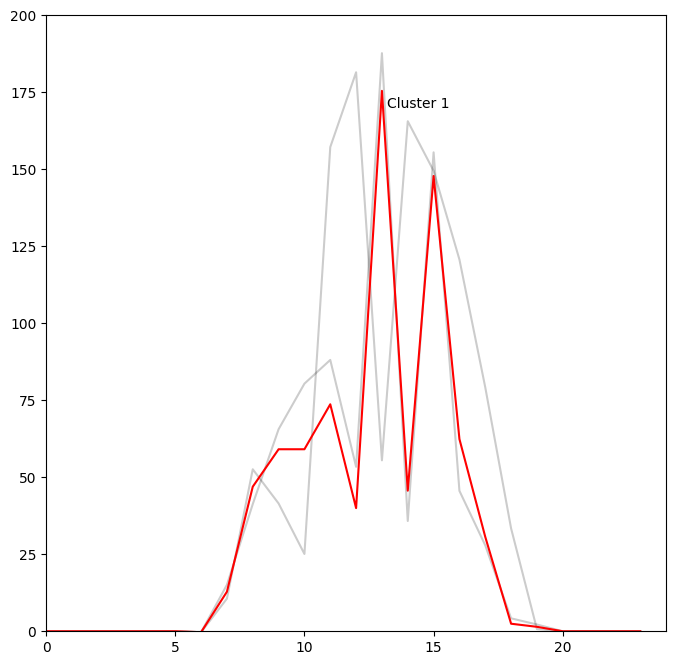

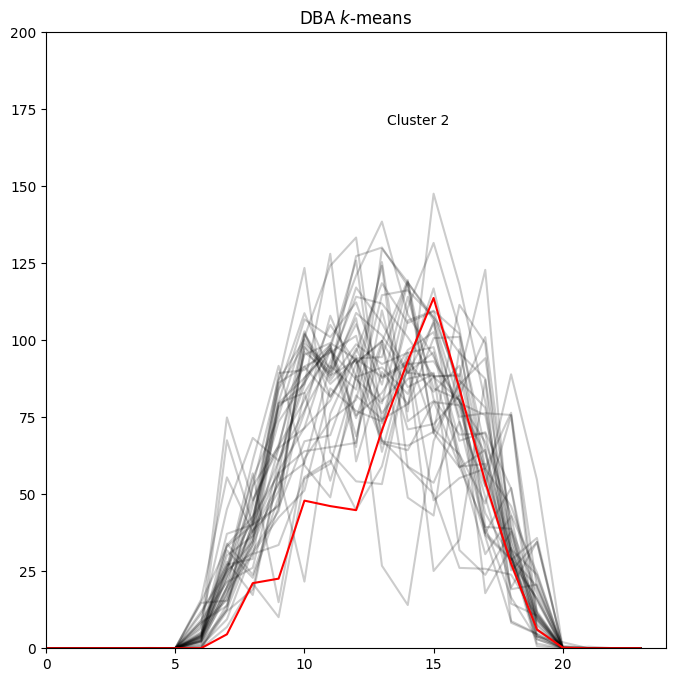

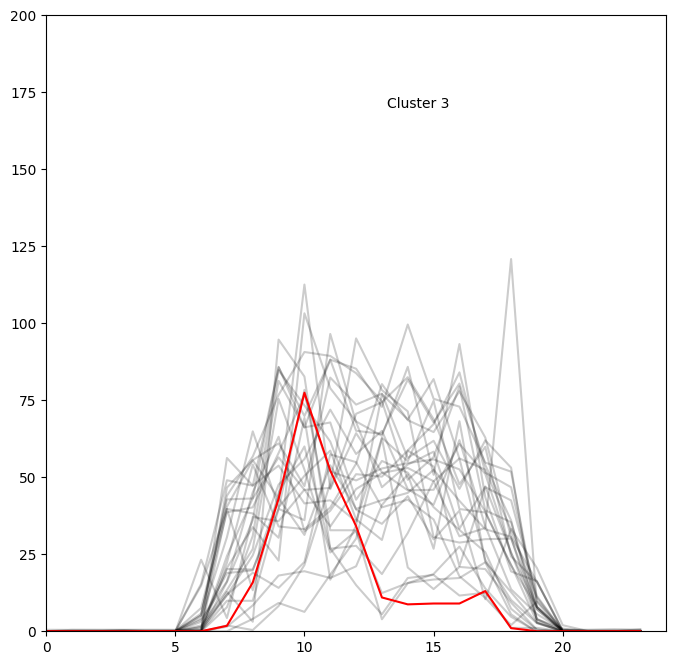

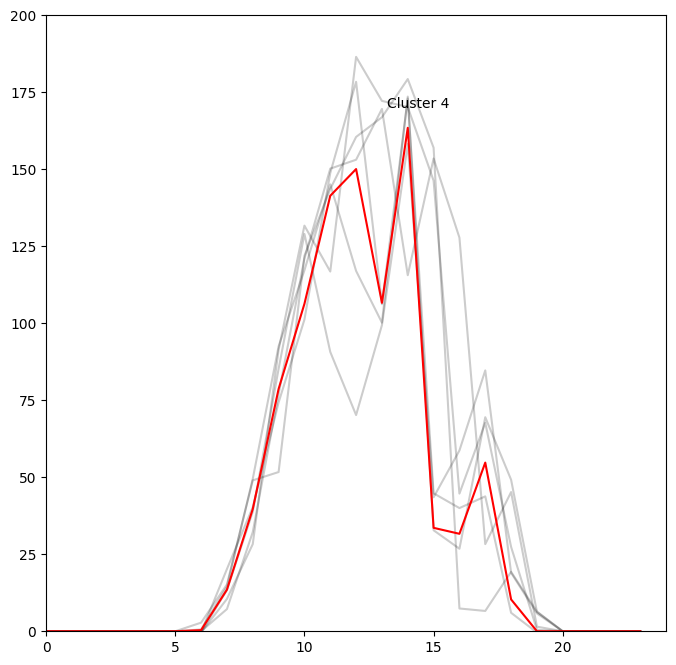

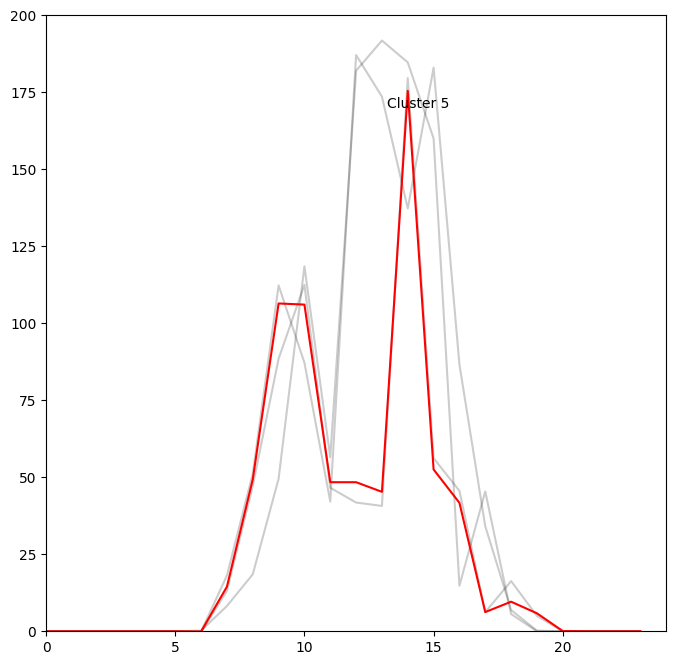

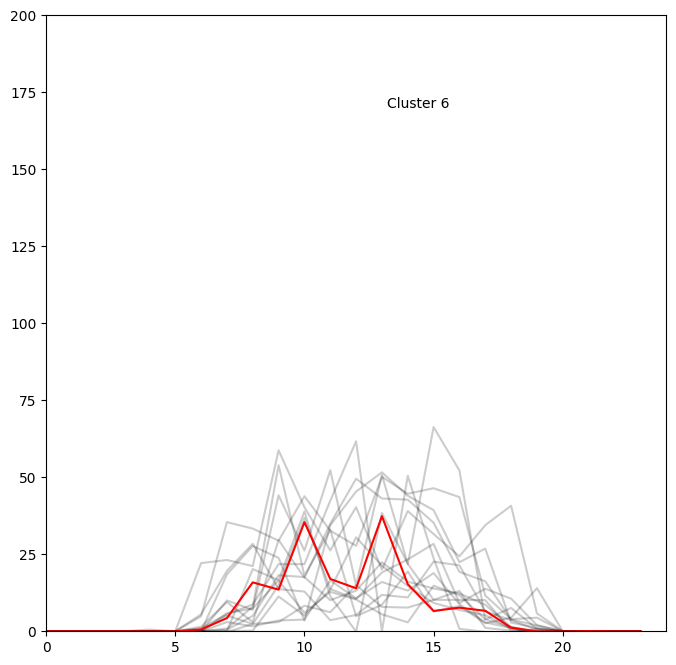

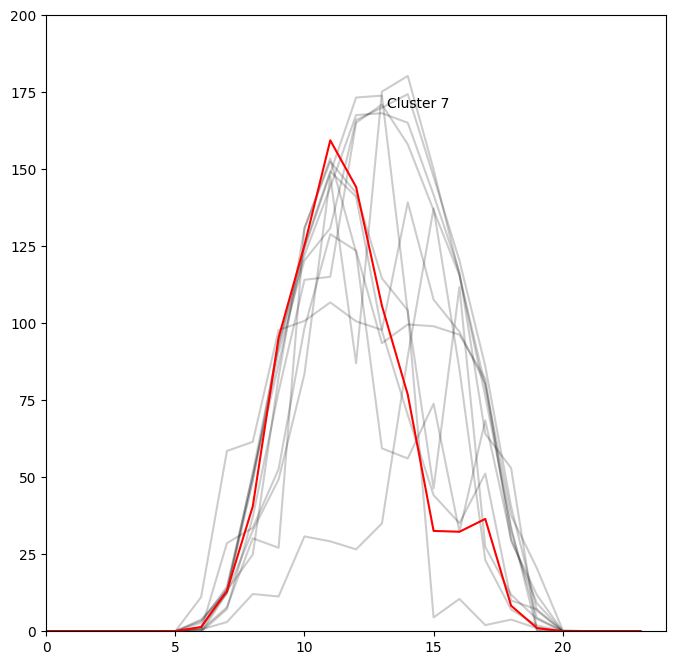

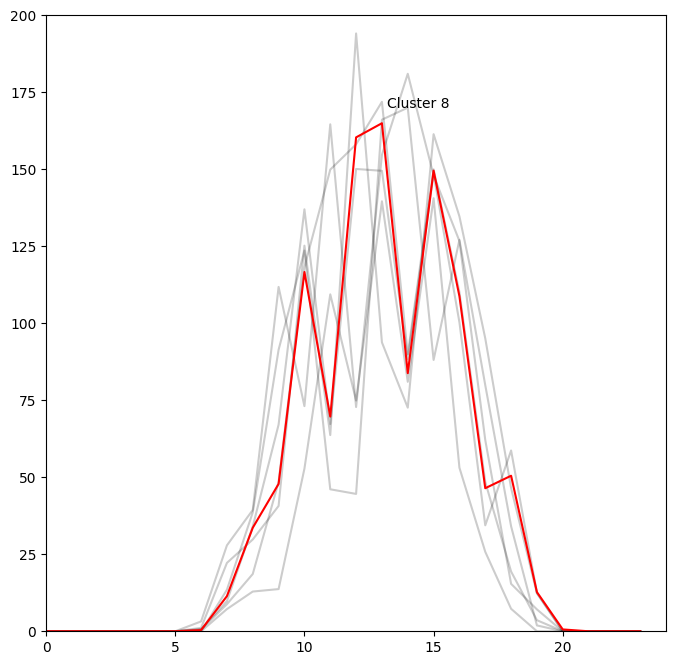

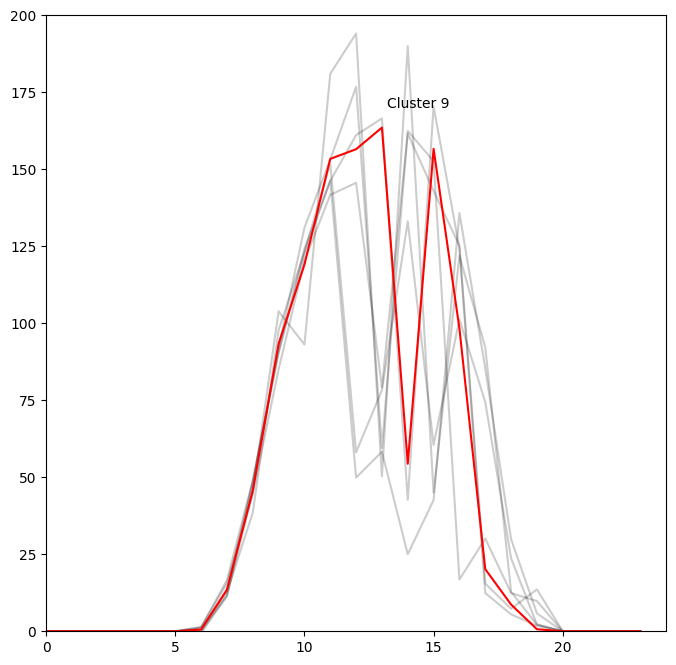

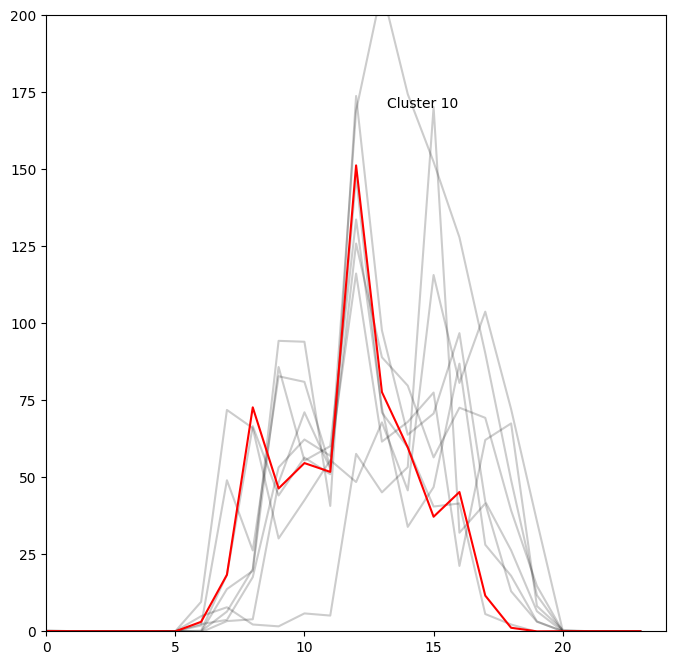

In [31]:
# sz = y_pred.shape[0]
sz = time_steps

for yi in range(k):
    
    # plt.subplot(10, 5, 1 + yi)
    plt.figure(figsize=(8, 8))
    for xx in seq_y[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(model.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(0, 200)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("DBA $k$-means")

# xgb 모델 생성

In [32]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import pickle
from sklearn.model_selection import GridSearchCV

k = 10

for name in pv_e.columns:
    
    # 모델 불러오기
    with open(os.path.join("Data","model_kmeans", f'timeseries_kmeans_pv_{name.replace("/", "")}.pkl'), 'rb') as f:
        loaded_model = pickle.load(f)

    pv_data = pv_e[name]

    factor = merged_factor.copy()

    pv_df = pd.DataFrame(pv_data)
    pv_df_c = pd.concat([pv_df[name], factor], axis=1)


    time_steps = 24
    seq_x, seq_y = create_sequences_data(factor, pv_data, time_steps=time_steps)
    seq_y = np.array(seq_y).reshape(len(seq_y), 24)

    seq_pred = loaded_model.fit_predict(seq_y)

    # X = np.array(load_data[:24]).reshape(1,-1)      # 임시
    # cl_indice = loaded_model.predict(X)

    

    cl_list = []


    for i in range(k):
        cl_indice = i
        a = seq_pred == i
        cl_ = np.where(a == True)[0].tolist()

        cl_list.append(cl_)


        pv_cl_sub = pd.DataFrame(columns=pv_df_c.columns)

        # 군집별로 데이터프레임 추출 후 학습
        for ele in cl_list[int(cl_indice)]:
            si = ele * 24
            ei = (ele+1) * 24

            sub_df = pv_df_c.iloc[si:ei]
            pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)



        X = pv_cl_sub.drop(columns=name)
        y = pv_cl_sub[name]

        # 데이터 스케일링
        scaler = MinMaxScaler()

        scaled_X = scaler.fit_transform(X)
        scaled_y = scaler.fit_transform(np.array(y).reshape(-1,1))


        X_train, X_test, y_train, y_test = train_test_split(scaled_X, scaled_y, test_size=0.2, random_state=42)

        

        # 하이퍼파라미터 그리드 설정
        param_grid = {
            'max_depth': [3, 5, 7, 9],
            'learning_rate': [0.01, 0.1, 0.2],
            'n_estimators': [100, 200, 300]
        }

        xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=5, learning_rate=0.1, verbosity=0)
        grid_search = GridSearchCV(xgb_model, param_grid, cv=3, scoring='r2', verbose=1)
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_

        y_pred = best_model.predict(X_test)

        # 모델 저장
        best_model.save_model(os.path.join("Data","model_xgb", f'xgb_pv_{name.replace("/", "")}_{cl_indice}.json'))

        # 성능 평가 (평균 제곱 오차)
        mse = mean_squared_error(y_test, y_pred)
        print(f"col: {name}, Mean Squared Error: {mse}")
                

/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


Fitting 3 folds for each of 36 candidates, totalling 108 fits
col: 축구장_시간당발전량, Mean Squared Error: 0.04350554413960237
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 축구장_시간당발전량, Mean Squared Error: 0.011388707982036892
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 축구장_시간당발전량, Mean Squared Error: 0.015440730156065254
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 축구장_시간당발전량, Mean Squared Error: 0.0173264784441103
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 축구장_시간당발전량, Mean Squared Error: 0.03771563177840435
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 축구장_시간당발전량, Mean Squared Error: 0.0301432074029471
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 축구장_시간당발전량, Mean Squared Error: 0.02041653817462061
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 축구장_시간당발전량, Mean Squared Error: 0.015661381899839132
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 축구장_시간당발전량, Mean Squared Error: 0.027260830219912657
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 축구장_시간당발전량, Mean Squared Error: 0.012399495703985946


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


Fitting 3 folds for each of 36 candidates, totalling 108 fits
col: 학생회관_시간당발전량, Mean Squared Error: 0.02999997996192416
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 학생회관_시간당발전량, Mean Squared Error: 0.017797124860846836
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 학생회관_시간당발전량, Mean Squared Error: 0.022977736904022477
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 학생회관_시간당발전량, Mean Squared Error: 0.04614381584245799
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 학생회관_시간당발전량, Mean Squared Error: 0.009770600762779027
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 학생회관_시간당발전량, Mean Squared Error: 0.011156856059827618
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 학생회관_시간당발전량, Mean Squared Error: 0.026085143661028785
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 학생회관_시간당발전량, Mean Squared Error: 0.027870077141440262
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 학생회관_시간당발전량, Mean Squared Error: 0.048203355799341555
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 학생회관_시간당발전량, Mean Squared Error: 0.011879217808314736


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


Fitting 3 folds for each of 36 candidates, totalling 108 fits
col: 중앙창고_시간당발전량, Mean Squared Error: 0.017100539203056493
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 중앙창고_시간당발전량, Mean Squared Error: 0.017821273553298697
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 중앙창고_시간당발전량, Mean Squared Error: 0.024281783432233747
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 중앙창고_시간당발전량, Mean Squared Error: 0.02040442729904498
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 중앙창고_시간당발전량, Mean Squared Error: 0.019057227793391716
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 중앙창고_시간당발전량, Mean Squared Error: 0.02491676926657341
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 중앙창고_시간당발전량, Mean Squared Error: 0.07778534969828664
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 중앙창고_시간당발전량, Mean Squared Error: 0.038405648323116846
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 중앙창고_시간당발전량, Mean Squared Error: 0.013426894516829503
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 중앙창고_시간당발전량, Mean Squared Error: 0.027135692012487132


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


Fitting 3 folds for each of 36 candidates, totalling 108 fits
col: 학사과정_시간당발전량, Mean Squared Error: 0.024007591032661535
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 학사과정_시간당발전량, Mean Squared Error: 0.030546959825440485
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 학사과정_시간당발전량, Mean Squared Error: 0.041240358232136454
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 학사과정_시간당발전량, Mean Squared Error: 0.02259810096947573
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 학사과정_시간당발전량, Mean Squared Error: 0.027898036203485032
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 학사과정_시간당발전량, Mean Squared Error: 0.025021235328221637
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 학사과정_시간당발전량, Mean Squared Error: 0.02269114364604358
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 학사과정_시간당발전량, Mean Squared Error: 0.010604683419839434
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 학사과정_시간당발전량, Mean Squared Error: 0.011425407316183857
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 학사과정_시간당발전량, Mean Squared Error: 0.02199126308329336


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


Fitting 3 folds for each of 36 candidates, totalling 108 fits
col: 다산빌딩_시간당발전량, Mean Squared Error: 0.022745312532507587
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 다산빌딩_시간당발전량, Mean Squared Error: 0.013058042782349856
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 다산빌딩_시간당발전량, Mean Squared Error: 0.029452770678113284
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 다산빌딩_시간당발전량, Mean Squared Error: 0.029525850674633782
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 다산빌딩_시간당발전량, Mean Squared Error: 0.013962487579934568
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 다산빌딩_시간당발전량, Mean Squared Error: 0.013512292279579284
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 다산빌딩_시간당발전량, Mean Squared Error: 0.03485812302388142
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 다산빌딩_시간당발전량, Mean Squared Error: 0.013760730511417626
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 다산빌딩_시간당발전량, Mean Squared Error: 0.0575048382009815
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 다산빌딩_시간당발전량, Mean Squared Error: 0.009176648014415648


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


Fitting 3 folds for each of 36 candidates, totalling 108 fits
col: 시설관리동_시간당발전량, Mean Squared Error: 0.01754299528711398
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 시설관리동_시간당발전량, Mean Squared Error: 0.014513490350107532
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 시설관리동_시간당발전량, Mean Squared Error: 0.018850777989267292
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 시설관리동_시간당발전량, Mean Squared Error: 0.038003313283033274
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 시설관리동_시간당발전량, Mean Squared Error: 0.012983922869427338
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 시설관리동_시간당발전량, Mean Squared Error: 0.029015299854182813
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 시설관리동_시간당발전량, Mean Squared Error: 0.016021679909484887
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 시설관리동_시간당발전량, Mean Squared Error: 0.02490084710391059
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 시설관리동_시간당발전량, Mean Squared Error: 0.02125592224820572
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 시설관리동_시간당발전량, Mean Squared Error: 0.03665117567362929


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


Fitting 3 folds for each of 36 candidates, totalling 108 fits
col: 대학C동_시간당발전량, Mean Squared Error: 0.014578695796639956
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 대학C동_시간당발전량, Mean Squared Error: 6.121942486428501e-06
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 대학C동_시간당발전량, Mean Squared Error: 0.012652200482414106
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 대학C동_시간당발전량, Mean Squared Error: 0.01308832312496329
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 대학C동_시간당발전량, Mean Squared Error: 0.02493903988354522
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 대학C동_시간당발전량, Mean Squared Error: 0.018397046375376386
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 대학C동_시간당발전량, Mean Squared Error: 0.027182483535042254
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 대학C동_시간당발전량, Mean Squared Error: 0.04233676843524104
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 대학C동_시간당발전량, Mean Squared Error: 0.05529445006650877
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 대학C동_시간당발전량, Mean Squared Error: 0.04950988138987006


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


Fitting 3 folds for each of 36 candidates, totalling 108 fits
col: 동물실험동_시간당발전량, Mean Squared Error: 0.016334208927673868
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 동물실험동_시간당발전량, Mean Squared Error: 0.032902275001282316
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 동물실험동_시간당발전량, Mean Squared Error: 0.037938932213395365
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 동물실험동_시간당발전량, Mean Squared Error: 0.03157620753302007
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 동물실험동_시간당발전량, Mean Squared Error: 0.011703205866276344
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 동물실험동_시간당발전량, Mean Squared Error: 0.01851253428106643
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 동물실험동_시간당발전량, Mean Squared Error: 0.012784990613367209
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 동물실험동_시간당발전량, Mean Squared Error: 0.02186661205767831
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 동물실험동_시간당발전량, Mean Squared Error: 0.04432112716004261
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 동물실험동_시간당발전량, Mean Squared Error: 0.022931125232954642


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


Fitting 3 folds for each of 36 candidates, totalling 108 fits
col: 중앙도서관_시간당발전량, Mean Squared Error: 0.018081461353949623
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 중앙도서관_시간당발전량, Mean Squared Error: 0.01472356649900375
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 중앙도서관_시간당발전량, Mean Squared Error: 0.027828507125199874
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 중앙도서관_시간당발전량, Mean Squared Error: 0.024603821157935076
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 중앙도서관_시간당발전량, Mean Squared Error: 0.022991484092536207
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 중앙도서관_시간당발전량, Mean Squared Error: 0.009233429114697331
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 중앙도서관_시간당발전량, Mean Squared Error: 0.04324400557670711
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 중앙도서관_시간당발전량, Mean Squared Error: 0.01600648506053484
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 중앙도서관_시간당발전량, Mean Squared Error: 0.023392633745919794
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 중앙도서관_시간당발전량, Mean Squared Error: 0.027287279148288383


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


Fitting 3 folds for each of 36 candidates, totalling 108 fits
col: LG도서관_시간당발전량, Mean Squared Error: 0.023710383721720782
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: LG도서관_시간당발전량, Mean Squared Error: 0.017768577771700864
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: LG도서관_시간당발전량, Mean Squared Error: 0.03200923834766421
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: LG도서관_시간당발전량, Mean Squared Error: 0.013111084941974578
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: LG도서관_시간당발전량, Mean Squared Error: 0.026246334514623288
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: LG도서관_시간당발전량, Mean Squared Error: 0.012199631420468631
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: LG도서관_시간당발전량, Mean Squared Error: 0.009566525994737559
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: LG도서관_시간당발전량, Mean Squared Error: 0.022585775904585728
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: LG도서관_시간당발전량, Mean Squared Error: 0.020703506972839625
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: LG도서관_시간당발전량, Mean Squared Error: 0.032654733206296624


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


Fitting 3 folds for each of 36 candidates, totalling 108 fits
col: 신재생에너지동_시간당발전량, Mean Squared Error: 0.014800262628358202
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 신재생에너지동_시간당발전량, Mean Squared Error: 0.016266762889702066
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 신재생에너지동_시간당발전량, Mean Squared Error: 0.03270865964188857
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 신재생에너지동_시간당발전량, Mean Squared Error: 0.030973037845300446
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 신재생에너지동_시간당발전량, Mean Squared Error: 0.02895207758426397
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 신재생에너지동_시간당발전량, Mean Squared Error: 0.03759259804337267
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 신재생에너지동_시간당발전량, Mean Squared Error: 0.03605453189448817
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 신재생에너지동_시간당발전량, Mean Squared Error: 0.006109827287561001
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 신재생에너지동_시간당발전량, Mean Squared Error: 0.014686591100651552
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 신재생에너지동_시간당발전량, Mean Squared Error: 0.012921191007052343


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


Fitting 3 folds for each of 36 candidates, totalling 108 fits
col: 삼성환경동_시간당발전량, Mean Squared Error: 0.045584981750095566
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 삼성환경동_시간당발전량, Mean Squared Error: 0.018568640120380415
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 삼성환경동_시간당발전량, Mean Squared Error: 0.01654311900522372
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 삼성환경동_시간당발전량, Mean Squared Error: 0.0155797616624389
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 삼성환경동_시간당발전량, Mean Squared Error: 0.029876156290367967
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 삼성환경동_시간당발전량, Mean Squared Error: 0.010149500796688419
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 삼성환경동_시간당발전량, Mean Squared Error: 0.018995951226623137
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 삼성환경동_시간당발전량, Mean Squared Error: 0.035356904741930796
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 삼성환경동_시간당발전량, Mean Squared Error: 0.03603950386247265
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 삼성환경동_시간당발전량, Mean Squared Error: 0.02140531470004056


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


Fitting 3 folds for each of 36 candidates, totalling 108 fits
col: 중앙연구기기센터_시간당발전량, Mean Squared Error: 0.02034358556993184
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 중앙연구기기센터_시간당발전량, Mean Squared Error: 0.014157502377508064
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 중앙연구기기센터_시간당발전량, Mean Squared Error: 0.023986043565893067
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 중앙연구기기센터_시간당발전량, Mean Squared Error: 0.01658648122674796
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 중앙연구기기센터_시간당발전량, Mean Squared Error: 0.01624011729225362
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 중앙연구기기센터_시간당발전량, Mean Squared Error: 0.025297317147247145
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 중앙연구기기센터_시간당발전량, Mean Squared Error: 0.014194238749760982
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 중앙연구기기센터_시간당발전량, Mean Squared Error: 0.047395993928773125
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 중앙연구기기센터_시간당발전량, Mean Squared Error: 0.049838834032633186
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 중앙연구기기센터_시간당발전량, Mean Squared Error: 0.025824192225155036


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


Fitting 3 folds for each of 36 candidates, totalling 108 fits
col: 산업협력관_시간당발전량, Mean Squared Error: 0.01331648014890549
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 산업협력관_시간당발전량, Mean Squared Error: 0.015774300361672346
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 산업협력관_시간당발전량, Mean Squared Error: 0.016930275692856243
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 산업협력관_시간당발전량, Mean Squared Error: 0.01764713636094222
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 산업협력관_시간당발전량, Mean Squared Error: 0.020757391547208657
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 산업협력관_시간당발전량, Mean Squared Error: 0.03841835207488859
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 산업협력관_시간당발전량, Mean Squared Error: 0.02167769291310959
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 산업협력관_시간당발전량, Mean Squared Error: 0.03138817437046028
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 산업협력관_시간당발전량, Mean Squared Error: 0.026532953298839156
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 산업협력관_시간당발전량, Mean Squared Error: 0.026127982638524068


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


Fitting 3 folds for each of 36 candidates, totalling 108 fits
col: 기숙사 B동_시간당발전량, Mean Squared Error: 0.009193482394740814
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 기숙사 B동_시간당발전량, Mean Squared Error: 0.015253322877586978
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 기숙사 B동_시간당발전량, Mean Squared Error: 0.030892116975746543
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 기숙사 B동_시간당발전량, Mean Squared Error: 0.026620122944046632
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 기숙사 B동_시간당발전량, Mean Squared Error: 0.021998273006851587
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 기숙사 B동_시간당발전량, Mean Squared Error: 0.02683537114258168
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 기숙사 B동_시간당발전량, Mean Squared Error: 0.02261380197384919
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 기숙사 B동_시간당발전량, Mean Squared Error: 0.019879632605279803
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 기숙사 B동_시간당발전량, Mean Squared Error: 0.018418018023355933
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 기숙사 B동_시간당발전량, Mean Squared Error: 0.032987516287419145


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


Fitting 3 folds for each of 36 candidates, totalling 108 fits
col: 자연과학동_시간당발전량, Mean Squared Error: 0.08120140058374983
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 자연과학동_시간당발전량, Mean Squared Error: 0.014098461182119486
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 자연과학동_시간당발전량, Mean Squared Error: 0.017277788090579886
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 자연과학동_시간당발전량, Mean Squared Error: 0.04767065875744951
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 자연과학동_시간당발전량, Mean Squared Error: 0.037179906218704574
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 자연과학동_시간당발전량, Mean Squared Error: 0.027096278659773713
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 자연과학동_시간당발전량, Mean Squared Error: 0.016163711596217857
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 자연과학동_시간당발전량, Mean Squared Error: 0.03632729433318569
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 자연과학동_시간당발전량, Mean Squared Error: 0.07578723921064107
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_24078/2083085705.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


col: 자연과학동_시간당발전량, Mean Squared Error: 0.014646885504473711


# 31일 예측

In [65]:
import pickle
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler

RESULT = []

for name in pv_e.columns:
    factor = merged_factor[-24:]
    
    test_value = test[name]
    test_df = pd.concat([test_value, factor], axis=1)

    # 모델 불러오기
    with open(os.path.join("Data","model_kmeans", f'timeseries_kmeans_pv_{name.replace("/", "")}.pkl'), 'rb') as f:
        loaded_model = pickle.load(f)

    # 부하 모형 분류
    cl_indice = int(loaded_model.predict(np.array(test_value).reshape(1,-1)))

    scaler = MinMaxScaler()
    X = test_df.drop(columns=name)
    y = test_df[name]

    test_X = scaler.fit_transform(X)
    test_y = scaler.fit_transform(np.array(y).reshape(1,-1))[0]
    
    # xgb-k 모델 불러오기
    xgbk = xgb.Booster()
    xgbk.load_model(os.path.join("Data","model_xgb", f'xgb_pv_{name.replace("/", "")}_{cl_indice}.json'))

    # 예측
    dtest = xgb.DMatrix(test_X)
    y_pred = xgbk.predict(dtest)

    output = scaler.inverse_transform(y_pred.reshape(1,-1))
    RESULT.append(output)

    # 성능 평가 (평균 제곱 오차)
    mse = mean_squared_error(test_y, y_pred)
    print(f"Mean Squared Error: {mse}")

Mean Squared Error: 0.10899411779762215
Mean Squared Error: 0.06831462360460784
Mean Squared Error: 0.11406677894353424
Mean Squared Error: 0.11826377677698391
Mean Squared Error: 0.0420673326857783
Mean Squared Error: 0.15302826572700234
Mean Squared Error: 0.007035125114112366
Mean Squared Error: 0.1472577201972854
Mean Squared Error: 0.07952192765307957
Mean Squared Error: 0.07609040634108377
Mean Squared Error: 0.12327956474346859
Mean Squared Error: 0.06015270022322625
Mean Squared Error: 0.16835433371624117
Mean Squared Error: 0.11782171265894394
Mean Squared Error: 0.12775678485626
Mean Squared Error: 0.12355424553564627


In [66]:
result = np.zeros((1,24))
for v in RESULT:
    result = result + v

pd.DataFrame(result.reshape(24,1), columns=["pv"]).to_csv(os.path.join("result", "PV_RESULT.csv"))

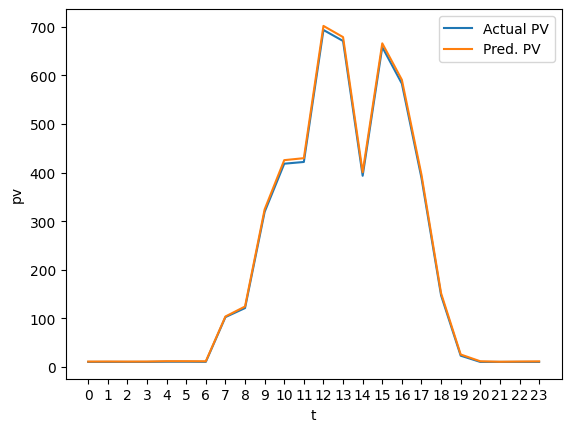

In [71]:
result_ = result.tolist()[0]
test_ = test.sum(axis=1)

plt.xlabel('t')
plt.ylabel('pv')
plt.xticks(ticks=[i for i in range(24)], labels=[i for i in range(24)])

plt.plot(test_, label="Actual PV")
plt.plot(result_, label="Pred. PV")
plt.legend()